In [1]:
# %% Importing the libraries

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torchvision.transforms as T
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25

In [2]:
#%% Import Class & Functions

from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Python')

# CNN Class
import Class.CNN_AE as CNN

# Function
from Function.dSplit import dSplit
import Function.LossFunc as LF
import Function.myDataset as mD

Mounted at /content/drive


In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
#%% Import data

# download CIFAR10
dataset = torchvision.datasets.CIFAR10(root='cifar10', download=True) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
Size: (50000, 32, 32, 3)

Categories-str: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Categories-int: [0 1 2 3 4 5 6 7 8 9]



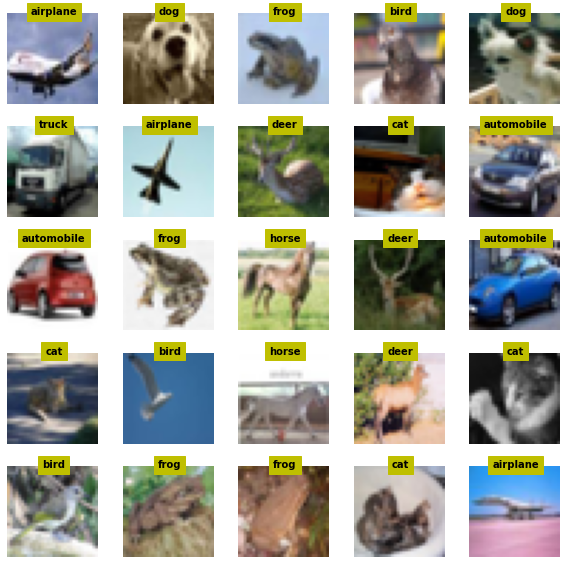

In [5]:
#%% Inspect Data

print(dataset)
print(f'Size: {dataset.data.shape}\n')
print(f'Categories-str: {dataset.classes}\n')
print(f'Categories-int: {np.unique(dataset.targets)}\n')

# plot random 10 pictures
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for ax in axs.flatten():

    # random index
    randidx = np.random.choice(len(dataset.targets))
    
    # extract image
    img = dataset.data[randidx, :, :, :]
    # label
    label = dataset.classes[dataset.targets[randidx]]
    
    # image
    ax.imshow(img)
    ax.text(16, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')


In [6]:
#%% Prepocessing

# numpy to tensor
# Pytorch image size (N-batch, RGB, width, height)
dat_X = torch.tensor(dataset.data).float()
dat_X = dat_X.permute(0, 3, 1, 2)
dat_X = dat_X / torch.max(dat_X)
# dat_X = dat_X[:, 0, :, :]
# dat_X = dat_X[:, None, :, :]
dat_X.shape

dat_y = torch.tensor(dataset.targets)
labels = dataset.classes

# Transform

# tf_mean = [torch.mean(dat_X[:, i, :, :]) for i in range(dat_X.shape[1])]
# tf_std = [torch.std(dat_X[:, i, :, :]) for i in range(dat_X.shape[1])]

# tf = T.Compose([
#                 T.Normalize(tf_mean, tf_std),
#                 T.ToPILImage(),
#                 # T.RandomVerticalFlip(p=.5),
#                 # T.RandomRotation(90), 
#                 T.ToTensor()
#                 ])

# Tensors to Dataset
# Dataset_train = mD.myDataset((dat_X, dat_X), tf)
Dataset_train = TensorDataset(dat_X, dat_X)

# Dataset to DataLoader
DataLoader_train = DataLoader(Dataset_train, batch_size=32)

In [8]:
# %% Create/Train model

# experiment parameters
optimTypes = ['Adam']
# dataLoaderSet = [[DataLoader_train, DataLoader_dev], [DataLoader_train_na, DataLoader_dev_na]]
lr = [0.001]

model_params_0 = optimTypes
model_params_1 = lr

# model parameters
epochs = 10
dr = 0

# store result
# list_y_pred_params_0 = []
list_losses_train_params_0 = []
list_acc_ep_train_params_0 = []
list_acc_ep_test_params_0 = []
# list_w_histx_params_0 = []
list_w_histy_params_0 = []
# nParams     = np.zeros( (len(model_params_0), len(model_params_1)) )
time_proc = np.zeros((len(model_params_0), len(model_params_1)))

# store predicted data from trained model
list_y_pred_model_params_0 = []



# store the best trained model
bestModel = {'Accuracy':0,
             'net':None,
             'params': (None, None),
             }

# Layers inputs
# Layers inputs
convLayers = {
        'conv0': {
            'in_channels': 3,
            'out_channels': 8,
            'kernel_size': 2,
            'stride': 1, # default=1
            'padding': 0
            },
        'conv1': {
            'in_channels': 8,
            'out_channels': 16,
            'kernel_size': 2,
            'stride': 1, # default=1
            'padding': 0
            },
        'conv2': {
            'in_channels': 16,
            'out_channels': 32,
            'kernel_size': 2,
            'stride': 1, # default=1
            'padding': 0
            }            
    }

poolLayers = {
        'pool0': {
            'kernel_size': 2,
            'stride': 1
            },
        'pool1': {
            'kernel_size': 2,
            'stride': 1
            },
        'pool2': {
            'kernel_size': 2,
            'stride': 1
            }
        }        

convDecLayer = {
        'convDec0': {
            'in_channels': 32,
            'out_channels': 16,
            'kernel_size': 3,
            'stride': 1, # default=1
            'padding': 0 # default=0
            },
        'convDec1': {
            'in_channels': 16,
            'out_channels': 8,
            'kernel_size': 3,
            'stride': 1, # default=1
            'padding': 0 # default=0
            },            
    }

outputLayer = {
        'output': {
            'in_channels': 8,
            'out_channels': 3,
            'kernel_size': 3,
            'stride': 1, # default=1
            'padding': 0 # default=0
            },
    }



# run experiments
for (e, param_0) in enumerate(model_params_0):

    # store result
    res_losses_train = np.zeros((len(model_params_1), epochs))
    res_acc_ep_train = np.zeros((len(model_params_1), epochs))
    res_acc_ep_test = np.zeros((len(model_params_1), epochs))
    res_w_histx = np.zeros((epochs, 100, len(model_params_1)))
    res_w_histy = np.zeros((epochs, 100, len(model_params_1)))
    # res_y_pred_train = np.zeros( (batch_size, len(np.unique(labels)), len(model_params_1)) )
    
    # store predicted data from trained model
    y_pred_model = []

    for (i, param_1) in enumerate(model_params_1):

        # timer
        time_start = time.process_time()

        # Model class instance
        CNN_model = CNN.CNN_Class()
        
        # construct layers
        CNN_model.setLayers(imgSize=32, 
                            convLayer=convLayers, 
                            poolLayer=poolLayers, 
                            convDecLayer=convDecLayer,
                            outputLayer=outputLayer,
                            # printToggle=True
                            )
        
        # set parameters
        CNN_model.setParams(dropout_rate=0,
                            learning_rate=param_1,
                            act_lib='torch',
                            conv_activation_fun='relu',  # activation function at convolution layers (fully-connected layers)
                            pool_lib='torch.nn.functional',
                            pool_fun='avg_pool2d',
                            optim_fun=param_0,
                            save_FeatMap=True
                            )

        dataloader_dict = {
            'DataLoader_train': DataLoader_train,
            'DataLoader_test': DataLoader_train,
            }

        # result during training per each epoch
        _, model_losses_train, model_acc_ep_train, model_acc_ep_test, _, model_w_histx, model_w_histy = CNN_model.trainModel(
            **dataloader_dict,
            epochs=epochs,
            loss_function='MSE',
            comp_acc_test=True,
            comp_w_hist=True,
            comp_w_change=False
        )

        res_losses_train[i, :] = model_losses_train.detach().numpy()

        res_acc_ep_train[i, :] = model_acc_ep_train.detach().numpy()

        # res_y_pred_train[:, :, i] = model_y_pred_train.detach().numpy()

        # accuracy comparing to test_set per each epoch
        res_acc_ep_test[i, :] = model_acc_ep_test.detach().numpy()

        # histogram weight
        res_w_histy[:, :, i] = model_w_histy

        # model parameters
        # nParams[e, i] = model_nParams

        # process time
        time_proc[e, i] = time.process_time() - time_start
        
        
    # Store result
    list_losses_train_params_0.append(res_losses_train)
    list_acc_ep_train_params_0.append(res_acc_ep_train)
    list_acc_ep_test_params_0.append(res_acc_ep_test)
    # list_w_histx_params_0.append(res_w_histx)
    list_w_histy_params_0.append(res_w_histy)
    # list_y_pred_params_0.append(res_y_pred_train)
    # list_y_pred_model_params_0.append(y_pred_model)
    
    # Store best model
    mean_acc = np.mean(list_acc_ep_test_params_0[-1][-1, :-5])
    if mean_acc > bestModel['Accuracy']:
        bestModel['Accuracy'] = mean_acc
        bestModel['net'] = copy.deepcopy(CNN_model.state_dict())
        bestModel['params'] = (e, i)


Text(0, 0.5, 'Density')

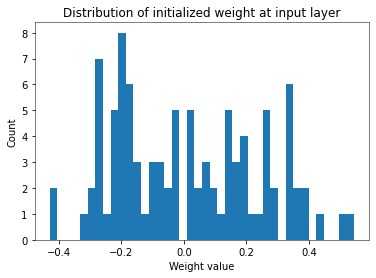

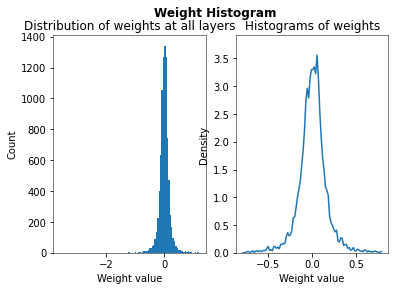

In [9]:
#%% explore the model's weight each layer

net_input_layer = vars(CNN_model.layers['conv0'])
net_input_layer_weight = CNN_model.layers['conv0'].weight.cpu()

# plot histogram of weight
plt.figure()
plt.hist(net_input_layer_weight.detach().flatten(), 40)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of initialized weight at input layer')


# weight at all layers
W = np.array([])

# get set of weights from each layer
for layer in CNN_model.layers:
    W = np.concatenate((W, CNN_model.layers[f'{layer}'].weight.cpu().detach().flatten().numpy() ))

# compute histogram
histy, histx = np.histogram(W, bins=np.linspace(-.8, .8, 101), density=True)
histx = (histx[1:] + histx[:-1])/2 # correct the dimension

# plot
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'Weight Histogram', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)

plt.subplot(1, 2, 1)
# plot histogram of weight (bar)
plt.hist(W, bins=100)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of weights at all layers')

plt.subplot(1, 2, 2)
plt.plot(histx, histy)
plt.ylim([0, np.max(histy)*1.1])
plt.title('Histograms of weights')
plt.xlabel('Weight value')
plt.ylabel('Density')


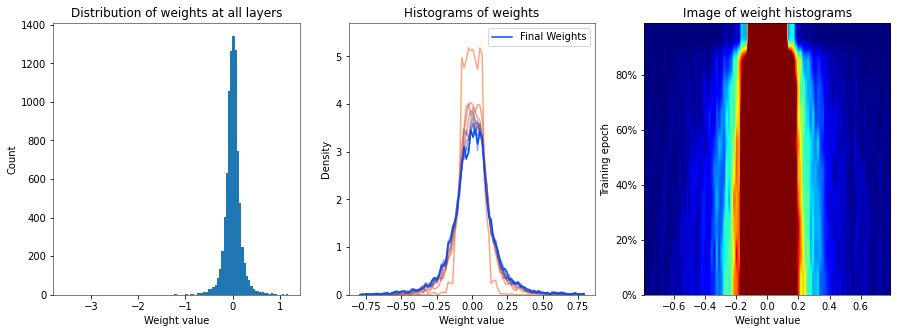

In [10]:
#%% Model's weight histogram of each epoch

# show the histogram of the weights

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

model_w_histy = list_w_histy_params_0[0][:, :, -1]

# plot histogram of weight (bar)
ax[0].hist(W, bins=100)
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of weights at all layers')


# plot histogram of weight (line)
w_len = len(model_w_histy)
for i in range(model_w_histy.shape[0]-1):
    ax[1].plot(model_w_histx, model_w_histy[i, :], color=[1-i/w_len, 0.3, i/w_len], alpha=0.5)
ax[1].plot(model_w_histx, model_w_histy[-1, :], color=[1-model_w_histy.shape[0]/w_len, 0.3, model_w_histy.shape[0]/w_len], label='Final Weights')
ax[1].set_title('Histograms of weights')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Density')
ax[1].legend()
ax[1].set_ylim([0, np.max(model_w_histy)*1.1])

# plot image of weight with epoch
ax[2].imshow(model_w_histy, vmin=0, vmax=0.8,
             extent=[model_w_histx[0], model_w_histx[-1], 0, 99], aspect='auto', origin='upper', cmap='jet')
ax[2].set_xlabel('Weight value')
ax[2].set_ylabel('Training epoch')
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax[2].set_title('Image of weight histograms')

plt.show()

Text(0.5, 1.0, 'MSE Loss by Epoch(test set)')

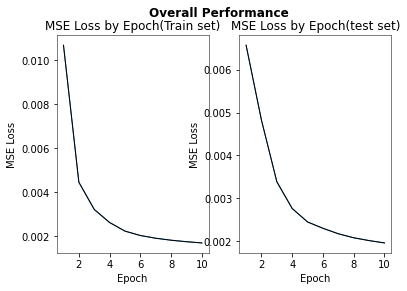

In [11]:
#%% plot model performance


# plot
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'Overall Performance', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)


# plot train-test acc-epoch by model
# plt.figure()
plt.subplot(1, 2, 1)
y_plot_1 = np.array(list_losses_train_params_0[0]).T
y_plot_2 = np.mean(np.array(list_losses_train_params_0[0]), axis=0)
# t, p = stats.ttest_ind(y_plot_1, y_plot_2)
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, 'k', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'MSE Loss by Epoch(Train set)')
# plt.legend([f'{param}' for param in model_params_1] + ['Mean'])
# plt.legend(['Kaiming', 'Xavier'])

plt.subplot(1, 2, 2)
y_plot_1 = np.array(list_acc_ep_test_params_0[0]).T
y_plot_2 = np.mean(np.array(list_acc_ep_test_params_0[0]), axis=0)
# plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
# t, p = stats.ttest_ind(y_plot_1, y_plot_2)
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, 'k', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'MSE Loss by Epoch(test set)')
# plt.legend([f'{param}' for param in model_params_1] + ['Mean'])
# plt.legend(['Kaiming', 'Xavier'])




torch.Size([3, 32, 32])

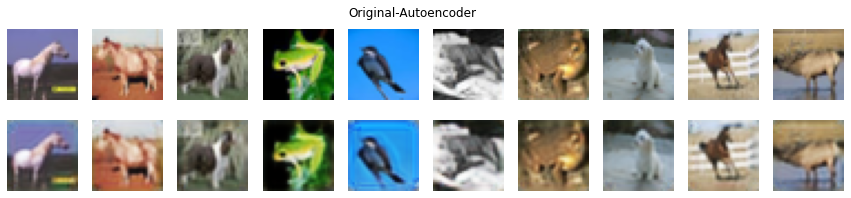

In [24]:
#%% Prediction from trained model

# sample to show
nPic = 10
randId = np.random.choice(len(dat_X), nPic, replace=False)

# run the model through for the test data
X = dat_X[randId, :, :, :].to(device)
predictions, _ = CNN_model.predict(X, X)
# predicitons = torch.sigmoid(predictions)

fig, axs = plt.subplots(2, nPic, figsize=(15, 3))
fig.suptitle('Original-Autoencoder')

# original images from teh ind test set
for axi in range(len(randId)):

    img_x = X[axi].cpu().permute(1, 2, 0)
    axs[0, axi].imshow(img_x)
    axs[0, axi].axis('off') 
    
    img_p = predictions[axi].cpu().permute(1, 2, 0)
    axs[1, axi].imshow(img_p)
    axs[1, axi].axis('off') 

X[axi].shape    

Text(0.5, 0.98, '1st convolution layer feature maps')

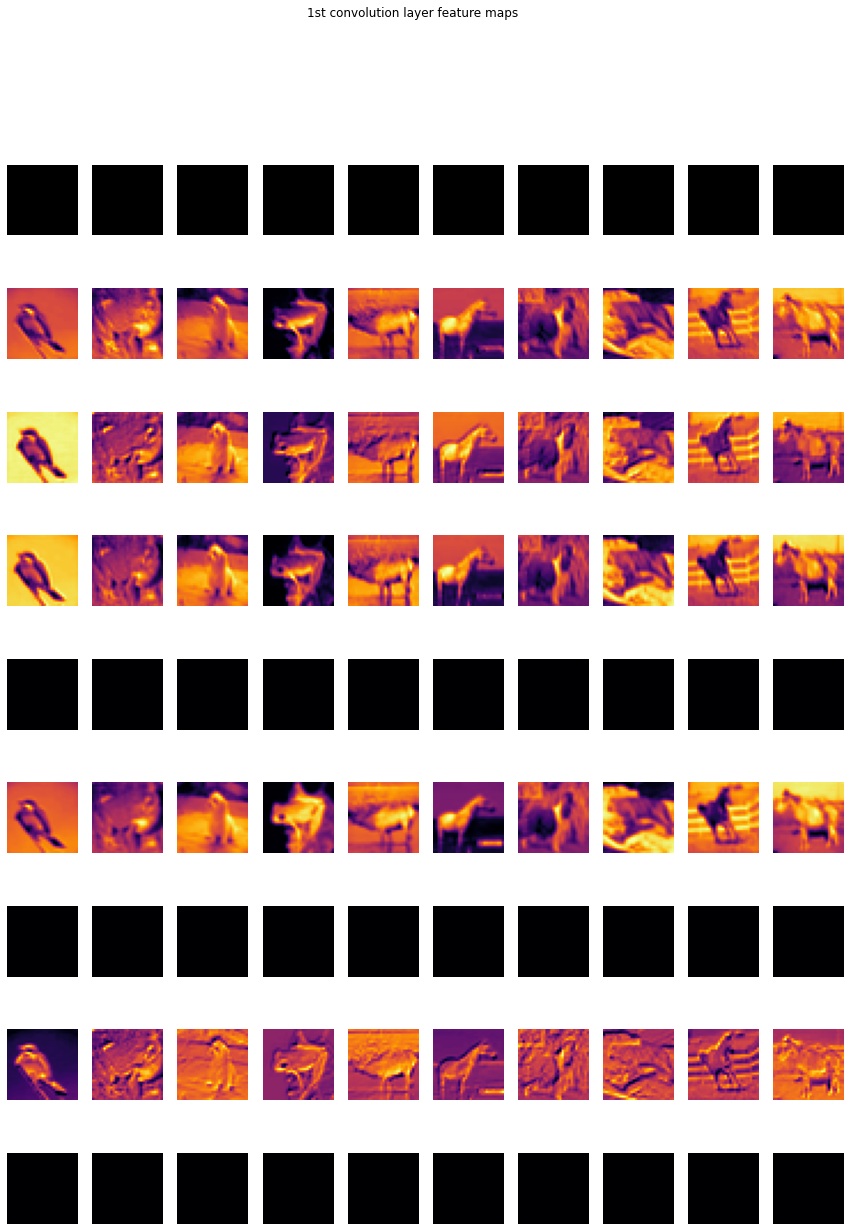

In [25]:
#%% explore the feature maps on independent test set

# ============================================================
# 1st conv layer's feature map
# ============================================================
fm = CNN_model.featureMaps['conv0']
fmSize = CNN_model.featureMaps['conv0'].shape

# plot 10 random images
nPic = 10
randId = np.random.choice(fmSize[0], nPic, replace=False)
fig, axs = plt.subplots(fmSize[1]+1, nPic, figsize=(15, 20))

# original images from teh ind test set
for axi, imgi in enumerate(randId):
  
    img = X.cpu().permute(0, 2, 3, 1).int()
    axs[0, axi].imshow(img[imgi])
    axs[0, axi].axis('off')
    # axs[0, axi].text(2, 2, f'T:{y[imgi].int().item()} P:{predictions[imgi].int().item()}', ha='left', va='top', color='k', fontweight='bold', backgroundcolor='w')
    
    # its feature maps
    for k in range(fmSize[1]):
        img = fm[imgi, k, :, :]
        axs[k+1, axi].imshow(img, cmap='inferno')
        axs[k+1, axi].axis('off')
        
plt.suptitle('1st convolution layer feature maps')


Text(0.5, 0.98, '2nd convolution layer feature maps')

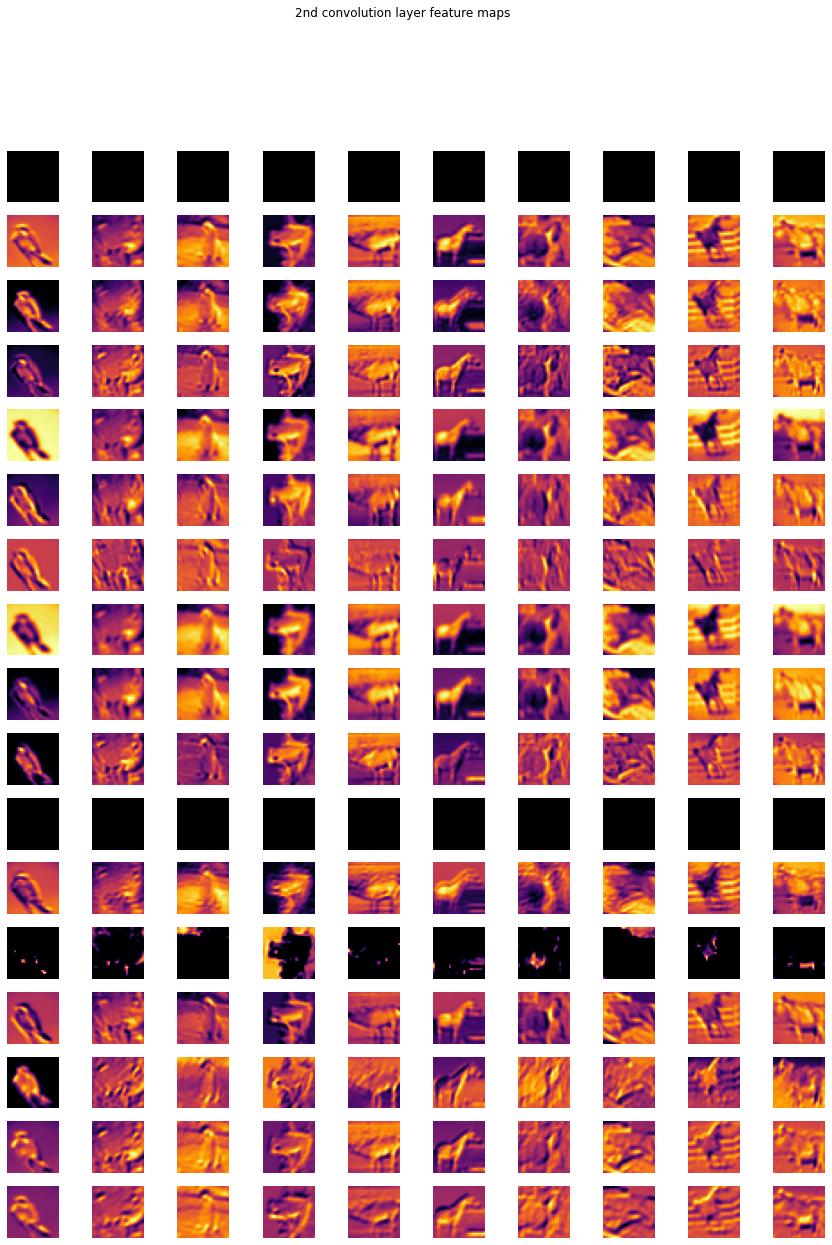

In [26]:
# ============================================================
# 2nd conv layer's feature map
# ============================================================
fm = CNN_model.featureMaps['conv1']
fmSize = CNN_model.featureMaps['conv1'].shape

fig, axs = plt.subplots(fmSize[1]+1, nPic, figsize=(15, 20))

# original images from teh ind test set
for axi, imgi in enumerate(randId):

    img = X.cpu().permute(0, 2, 3, 1).int()
    axs[0, axi].imshow(img[imgi])
    axs[0, axi].axis('off')
    
    # its feature maps
    for k in range(fmSize[1]):
        img = fm[imgi, k, :, :]
        axs[k+1, axi].imshow(img, cmap='inferno')
        axs[k+1, axi].axis('off')
        # axs[0, axi].text(2, 2, f'T:{y[imgi].int().item()} P:{predictions[imgi].int().item()}', ha='left', va='top', color='k', fontweight='bold', backgroundcolor='w')

plt.suptitle('2nd convolution layer feature maps')

In [27]:
# ============================================================
# 3rd conv layer's feature map
# ============================================================
fm = CNN_model.featureMaps['conv2']
fmSize = CNN_model.featureMaps['conv2'].shape

fig, axs = plt.subplots(fmSize[1]+1, nPic, figsize=(15, 80))

# original images from teh ind test set
for axi, imgi in enumerate(randId):

    img = X.cpu().permute(0, 2, 3, 1).int()
    axs[0, axi].imshow(img[imgi])
    axs[0, axi].axis('off')
    
    # its feature maps
    for k in range(fmSize[1]):
        img = fm[imgi, k, :, :]
        axs[k+1, axi].imshow(img, cmap='inferno')
        axs[k+1, axi].axis('off')
        # axs[0, axi].text(2, 2, f'T:{y[imgi].int().item()} P:{predictions[imgi].int().item()}', ha='left', va='top', color='k', fontweight='bold', backgroundcolor='w')

plt.suptitle('3rd convolution layer feature maps')

Output hidden; open in https://colab.research.google.com to view.